# Read and Examination of Data

In [1]:
# Import  pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import random
# Import matplotlib, seaborn for visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Import the data
df = pd.read_csv(r'C:\Users\danijel\Desktop\DataScience\data_final.csv')
# Nameing the columns of Date/Time and Temperature 
df.columns =['Date and Time', 'Temp']
# Getting rid of microseconds on dataset
df['Date and Time'] = df['Date and Time'].astype('datetime64[s]')
# Shape of dataset
print(df.shape)
# Reset the index
df.set_index('Date and Time', inplace=True)
df.head()

(383, 2)


,Temp
Date and Time,
2020-09-30 14:30:02,24.562
2020-09-30 15:00:02,24.250
2020-09-30 15:30:02,23.875
2020-09-30 16:00:02,23.875
2020-09-30 16:30:02,23.750


In [2]:
# Using the describe function to show count, mean, std etc...
df.describe()

,Temp
count,383.000000
mean,21.610723
std,0.812712
min,19.687000
25%,21.000000
50%,21.625000
75%,22.187000
max,24.562000


In [3]:
# Output the maximum and minimum temperature date
print(df.loc[df["Temp"] == df["Temp"].max()])
print(df.loc[df["Temp"] == df["Temp"].min()])

                       Temp
Date and Time              
2020-09-30 14:30:02  24.562
                       Temp
Date and Time              
2020-10-08 06:00:02  19.687


## Data Visualization

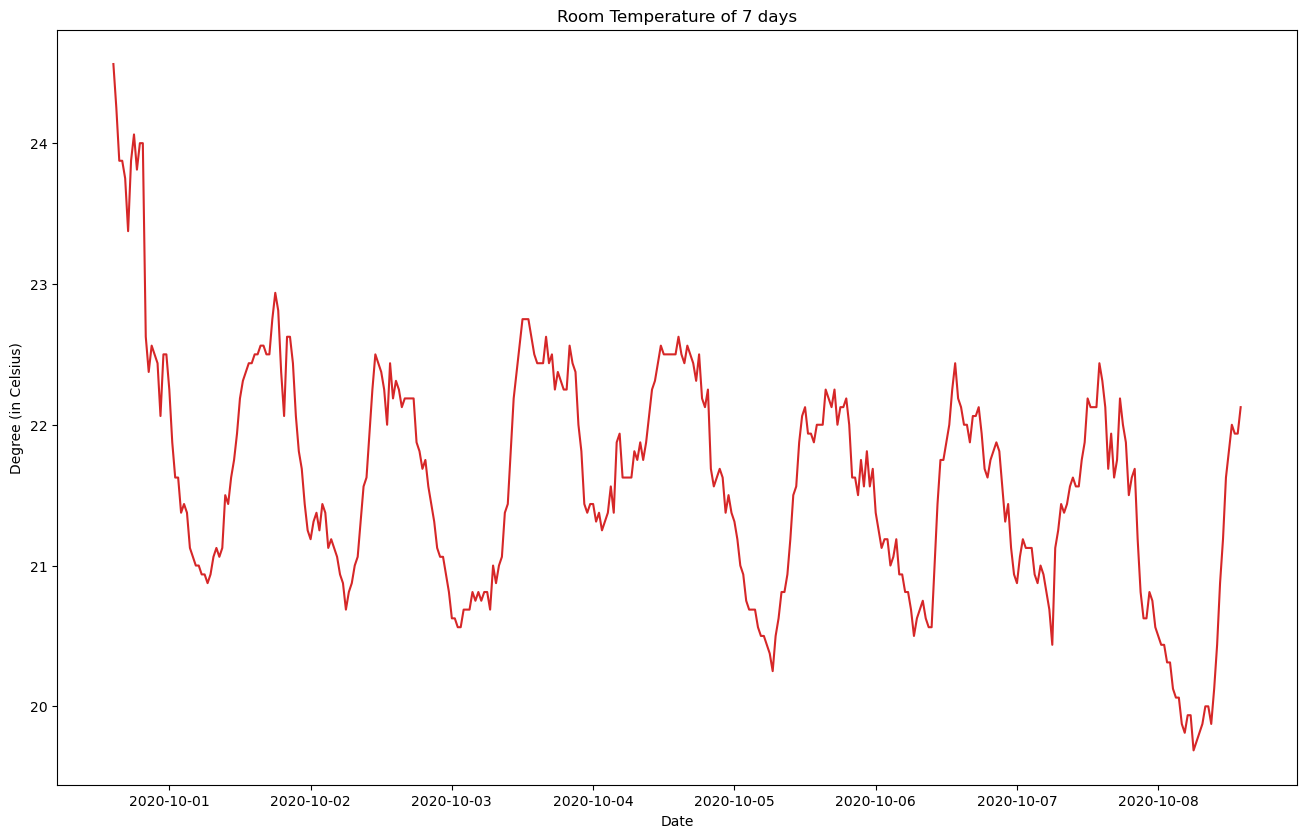

In [4]:
# Plotting the daily room temperature
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10), dpi=100)
plt.plot(df.index, df.Temp, color='tab:red')
plt.gca().set(title="Room Temperature of 7 days", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

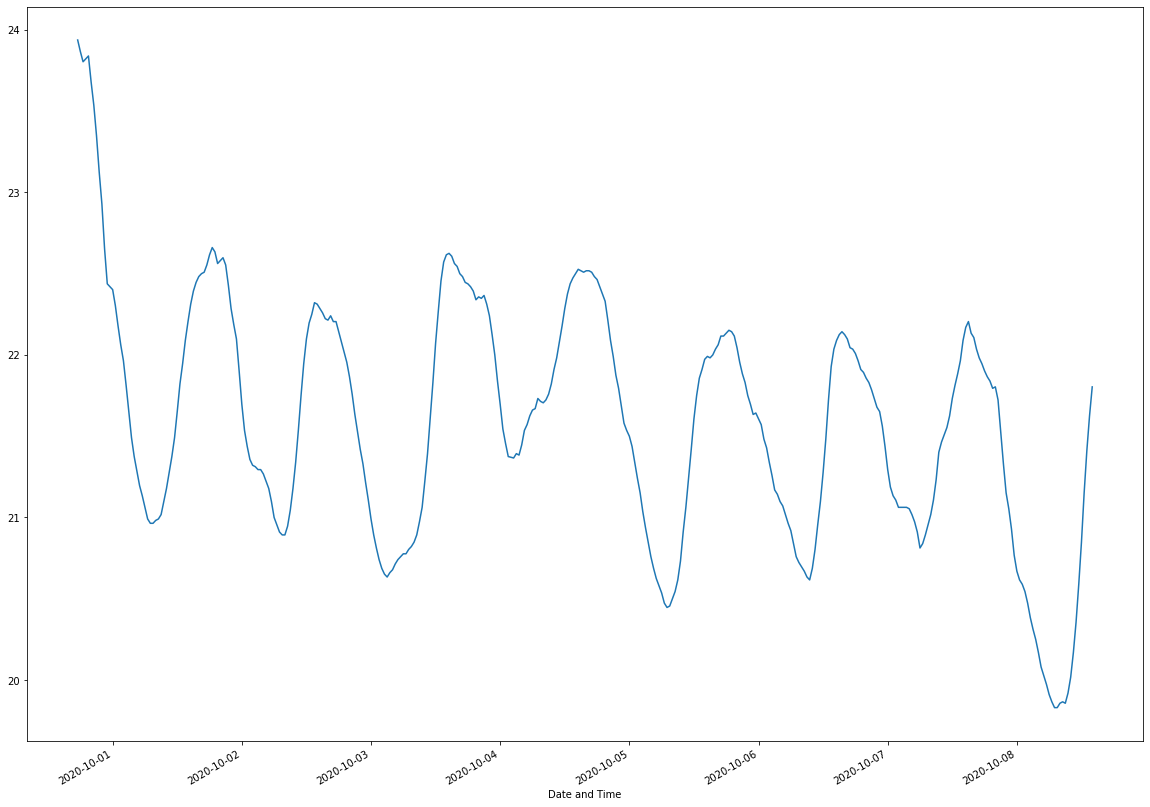

In [5]:
# Apply the Moving Average function by a subset of 7 days, in this case
temp_df_mean = df.Temp.rolling(window=7).mean()
temp_df_mean.plot(figsize=(20,15))

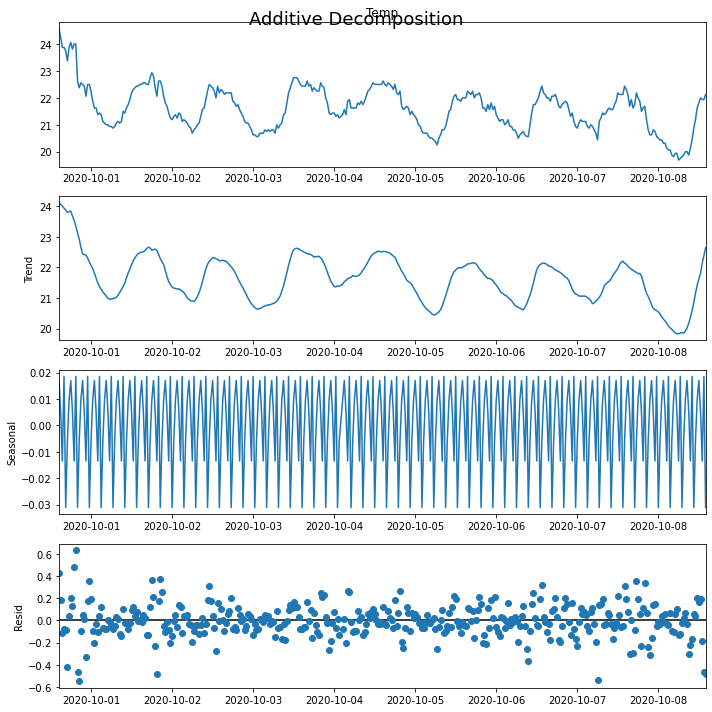

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df.Temp, model='additive', extrapolate_trend='freq', period=7)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=18)
plt.show()

## Baseline Model

In [7]:
# Shift the current temperature to the next day. 
predicted_df = df["Temp"].to_frame().shift(1).rename(columns = {"Temp": "Temp_pred" })
actual_df = df["Temp"].to_frame().rename(columns = {"Temp": "Temp_actual" })

# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(10)

,Temp_actual,Temp_pred
Date and Time,,
2020-09-30 15:00:02,24.250,24.562
2020-09-30 15:30:02,23.875,24.250
2020-09-30 16:00:02,23.875,23.875
2020-09-30 16:30:02,23.750,23.875
2020-09-30 17:00:02,23.375,23.750
2020-09-30 17:30:02,23.875,23.375
2020-09-30 18:00:02,24.062,23.875
2020-09-30 18:30:02,23.812,24.062
2020-09-30 19:00:02,24.000,23.812


In [8]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# Calculate the RMSE
temp_pred_err = sqrt(MSE(one_step_df.Temp_actual, one_step_df.Temp_pred))
print("The RMSE is",temp_pred_err)

The RMSE is 0.19781332757285336


## Weather Forecast using SARIMA model

In [9]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [19]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.Temp_actual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3424.990967654449
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3320.529433025288
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1004.1917322128065
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:854.4481030216862
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1006.5872698046973
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:863.0401080179747
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:952.238173360966
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:808.5124015782194
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2898.667752685267
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2819.3811585557187
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:610.314758413103
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:467.9447313778622
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1013.7981856166964
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:471.31740414740625
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:576.2306477438434
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:432.3647052801364
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-155.23819872027786
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-206.

## Fitting the SARIMAX Model

In [20]:
# Import the statsmodels library for using SARIMAX model
import statsmodels.api as sm

# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df.Temp_actual,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

## Model Diagnostics

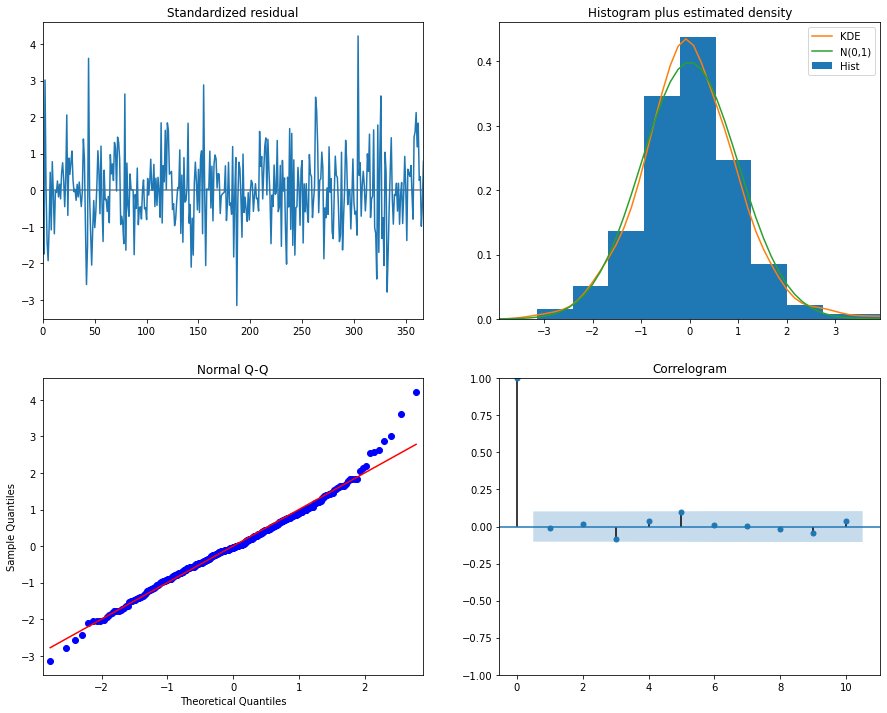

In [21]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Validating the Non-Dynamic Forecast

In [22]:
##non-dynamic forecast
pred = results.get_prediction(start=pd.to_datetime('2020-09-30 15:00:02'), dynamic=False)
pred_ci = pred.conf_int()

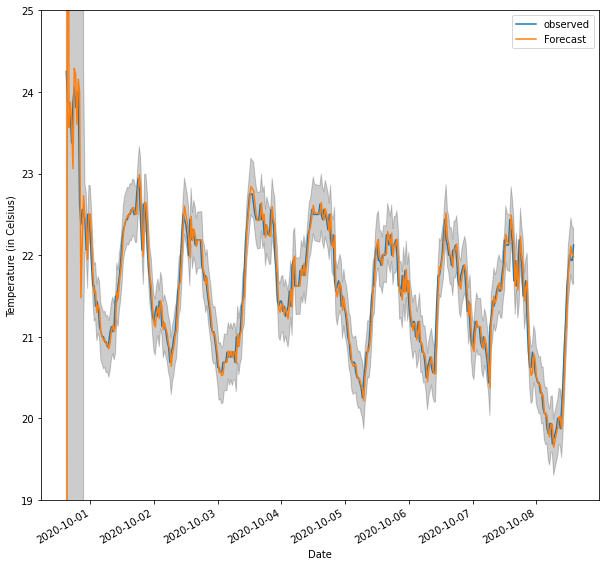

In [23]:
ax = one_step_df.Temp_actual['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([19,25])
plt.legend()
plt.show()

In [24]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.Temp_actual['2020-09-30 15:00:02':]
print(y_forecasted.shape)
print(y_truth.shape)
# Compute the mean square error
mse = sqrt(MSE(y_truth, y_forecasted).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

(382,)
(382,)
The Mean Squared Error of our forecasts is 1.37


## Validating the Dynamic Forecast

In [25]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-09-30 15:00:02'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

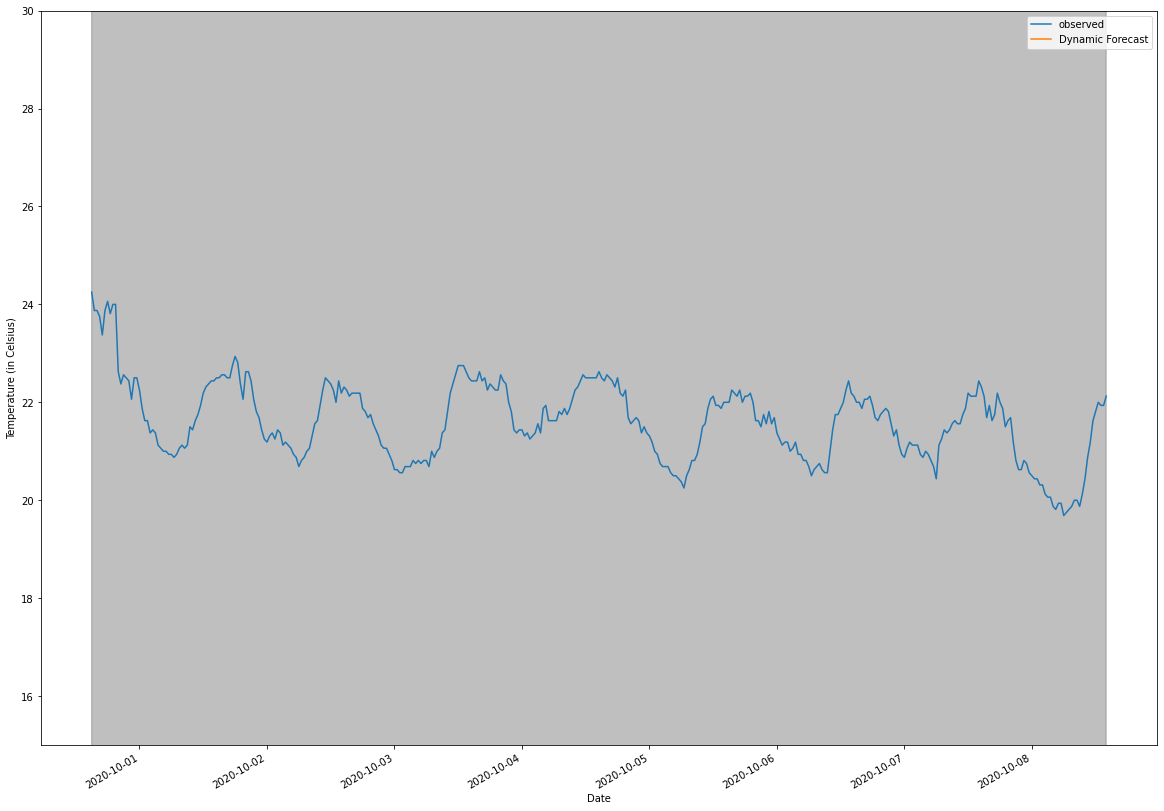

In [26]:

ax = one_step_df.Temp_actual['2020':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([15,30])
plt.legend()
plt.show()

In [27]:

# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = one_step_df.Temp_actual['2020-09-30 15:00:02':]

# Compute the mean square error
mse = sqrt(MSE(y_truth, y_forecasted).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 21.62
